In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

In [2]:
#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

- Given that the each image will be of size 64 x 64 x 3 (RBG)

In [4]:
#define the transformations
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
#define the batchsize
training_batchsize = 5

In [6]:
!pwd

C:\Users\NiranjanKumar\MyProjects\Character


In [7]:
#retrieve the full data
full_data = VowelConsonantDataset("train/",train=True,transform=transform)

#take the training size = 90% 
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

#split the training data into train and validation data
train_data, validation_data = random_split(full_data, [train_size, test_size])

#create a dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=training_batchsize, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=training_batchsize, shuffle=True)

In [8]:
#download the test data and define the test loader
test_data = VowelConsonantDataset("test/", train = False, transform = transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 30)

In [56]:
#create a iterator

dataiter = iter(train_loader)
images, labels = dataiter.next()

#shape of images bunch
print(images.shape)

#shape of first image in a group of 4
print(images[1].shape)

#class label for first image
print(labels[1])

torch.Size([5, 3, 32, 32])
torch.Size([3, 32, 32])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


In [57]:
labels

tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])

# Visualization of Data

In [11]:
#custom function to display images

def imshow(img, title):
    
    #convert image from tensor to numpy for visualization
    npimg = img.numpy()
    #define the size of a figure
    plt.figure(figsize = (10, 10))
    plt.axis("off")
    
    #interchaging the image sizes - transposing
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title, fontsize=15)
    plt.show()

In [12]:
#function to get images and feed into our custom function 'imshow'

def show_batch_images(dataloader):
    
    #getting the images
    images, labels = next(iter(dataloader))
    #make a grid from those images
    img = torchvision.utils.make_grid(images)
    
    #call our custom function
    imshow(img, title = ["V" + str(np.where(t[0].numpy() == 1)[0][0]) + "_C" + str(np.where(t[1].numpy() == 1)[0][0]) for t in labels])
    #imshow(img, title = [str(x.item()) for x in labels])  

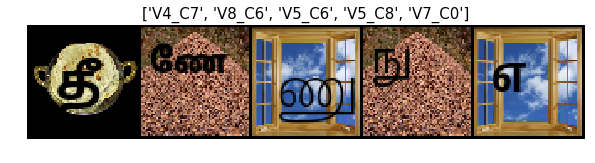

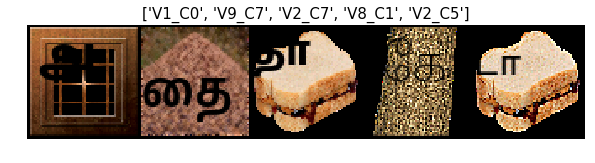

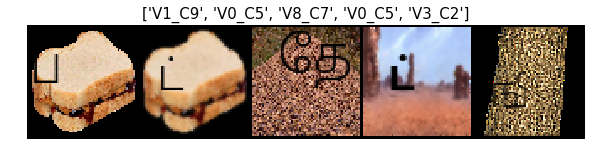

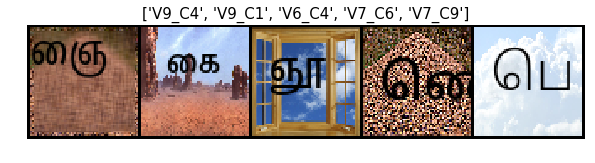

In [13]:
#visualize the training data

for i in range(4):
    show_batch_images(train_loader)

# Modeling

In [14]:
#checking for available gpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
from torchvision import models
import torch.optim as optim

In [16]:
#define the number of classes for the final layer
num_classes = 10 #10 vowels and 10 consonants

In [17]:
transform_train = transforms.Compose([
    #cropping and resizing the image to 224x224 
    transforms.RandomResizedCrop(32),
    #convert image to tensor
    transforms.ToTensor(),
    #normalizing the input mean = 0.5 and std = 0.5 for three channels (R,G,B)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#define the same operations to test data
transform_test = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [18]:
#retrieve the full data
full_data = VowelConsonantDataset("train/",train=True,transform=transform_train)

#take the training size = 90% 
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

#split the training data into train and validation data
train_data, validation_data = random_split(full_data, [train_size, test_size])

#create a dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=training_batchsize, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=training_batchsize, shuffle=True)

#download the test data and define the test loader
test_data = VowelConsonantDataset("test/", train = False, transform = transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = training_batchsize)

In [27]:
#Used ReLU non-linear activation instead of tanh

class LeNet_ReLU(nn.Module):
    def __init__(self): 
        super(LeNet_ReLU, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.ReLU(),
            nn.Linear(84,32)            # (N, 84)  -> (N, 32)
        )
        
        self.vowel = nn.Sequential(
            nn.Linear(32, num_classes),
            nn.Softmax(dim = 1)
        )
        
        self.consonant = nn.Sequential(
            nn.Linear(32, num_classes),
            nn.Softmax(dim = 1)
        )
        
        
    def forward(self, x):
        #print(x.shape)
        x = self.cnn_model(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        v = self.vowel(x)
        c = self.consonant(x)
        return v,c

# Training the Model
* Using the Modified LeNet

In [28]:
#create a iterator

dataiter = iter(train_loader)
images, labels = dataiter.next()

#shape of images bunch
print(images.shape)

#shape of first image in a group of 4
print(images[1].shape)

#class label for first image
print(labels[1])

torch.Size([5, 3, 32, 32])
torch.Size([3, 32, 32])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


In [58]:
#Train using the GPU
net = LeNet_ReLU()

In [59]:
out = net(images)

In [60]:
out[0].shape

torch.Size([5, 10])

In [61]:
labels

tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])

In [62]:
out

(tensor([[0.0923, 0.1026, 0.1031, 0.0937, 0.0927, 0.0932, 0.1108, 0.0883, 0.1173,
          0.1061],
         [0.0926, 0.1028, 0.1031, 0.0942, 0.0908, 0.0932, 0.1109, 0.0875, 0.1180,
          0.1070],
         [0.0932, 0.1022, 0.1037, 0.0940, 0.0924, 0.0925, 0.1102, 0.0895, 0.1171,
          0.1052],
         [0.0931, 0.1017, 0.1026, 0.0935, 0.0927, 0.0940, 0.1103, 0.0883, 0.1174,
          0.1063],
         [0.0920, 0.1022, 0.1041, 0.0928, 0.0946, 0.0927, 0.1090, 0.0895, 0.1172,
          0.1059]], grad_fn=<SoftmaxBackward>),
 tensor([[0.0887, 0.0933, 0.1104, 0.0814, 0.0989, 0.1033, 0.1114, 0.1134, 0.1132,
          0.0861],
         [0.0890, 0.0925, 0.1110, 0.0811, 0.0997, 0.1028, 0.1113, 0.1120, 0.1139,
          0.0867],
         [0.0883, 0.0931, 0.1103, 0.0812, 0.0994, 0.1028, 0.1116, 0.1150, 0.1122,
          0.0861],
         [0.0887, 0.0933, 0.1104, 0.0817, 0.0985, 0.1027, 0.1111, 0.1139, 0.1139,
          0.0857],
         [0.0879, 0.0932, 0.1101, 0.0811, 0.0980, 0.1022, 0.11

In [47]:
z1 = [label[0].numpy() for label in labels]
z1 = torch.FloatTensor(z1)
z1

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [65]:
out[0]

tensor([[0.0923, 0.1026, 0.1031, 0.0937, 0.0927, 0.0932, 0.1108, 0.0883, 0.1173,
         0.1061],
        [0.0926, 0.1028, 0.1031, 0.0942, 0.0908, 0.0932, 0.1109, 0.0875, 0.1180,
         0.1070],
        [0.0932, 0.1022, 0.1037, 0.0940, 0.0924, 0.0925, 0.1102, 0.0895, 0.1171,
         0.1052],
        [0.0931, 0.1017, 0.1026, 0.0935, 0.0927, 0.0940, 0.1103, 0.0883, 0.1174,
         0.1063],
        [0.0920, 0.1022, 0.1041, 0.0928, 0.0946, 0.0927, 0.1090, 0.0895, 0.1172,
         0.1059]], grad_fn=<SoftmaxBackward>)

In [40]:
z2 = [label[1].numpy() for label in labels]
z2 = torch.FloatTensor(z2)
z2

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [66]:
out[1]

tensor([[0.0887, 0.0933, 0.1104, 0.0814, 0.0989, 0.1033, 0.1114, 0.1134, 0.1132,
         0.0861],
        [0.0890, 0.0925, 0.1110, 0.0811, 0.0997, 0.1028, 0.1113, 0.1120, 0.1139,
         0.0867],
        [0.0883, 0.0931, 0.1103, 0.0812, 0.0994, 0.1028, 0.1116, 0.1150, 0.1122,
         0.0861],
        [0.0887, 0.0933, 0.1104, 0.0817, 0.0985, 0.1027, 0.1111, 0.1139, 0.1139,
         0.0857],
        [0.0879, 0.0932, 0.1101, 0.0811, 0.0980, 0.1022, 0.1145, 0.1147, 0.1128,
         0.0854]], grad_fn=<SoftmaxBackward>)

In [138]:
loss_fn = nn.BCELoss()
opt = optim.Adam(net.parameters())

In [49]:
loss1 = loss_fn(out[0], z1)

In [50]:
loss1.item()

0.3315931260585785

In [51]:
loss2 = loss_fn(out[1], z2)

In [52]:
loss2.item()

0.3171156346797943

In [ ]:
#loss list
loss_epoch_arr = []
max_epochs = 1

#define the number of iterations
n_iter = np.ceil(10000/training_batchsize)

#iterate or epochs
for epoch in range(max_epochs):
    
  
    #iterate through all the batches to complete one pass
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        #push to gpu
        inputs, labels = inputs, labels
        
        #set gradients to zero
        opt.zero_grad()
        
        #run the model
        outputs = net(inputs)
        
        #calculate the loss
        vloss = [label[0].numpy() for label in labels]
        vloss = torch.FloatTensor(z1)
        
        closs = [label[1].numpy() for label in labels]
        closs = torch.FloatTensor(z2)
        
        loss1 = loss_fn(outputs[0], vloss)
        loss2 = loss_fn(outputs[1], closs)
        #combined loss
        loss = loss1 + loss2
        
        #backpropagate the gradients
        loss.backward()
        opt.step()
        
        #clear memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print("Iteration: %d/%d, Loss: %0.2f" %(i, n_iter, loss.item()))
          
        loss_epoch_arr.append(loss.item())
        
        #print("epoch: %d/%d, train_acc: %0.2f" %(epoch, max_epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))


Iteration: 0/2000, Loss: 0.64
Iteration: 100/2000, Loss: 0.64
Iteration: 200/2000, Loss: 0.63


# VGG

In [104]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [140]:
class VGG_m(nn.Module):
    def __init__(self, vgg_name):
        super(VGG_m, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 100)
        self.vowel = nn.Sequential(
            nn.Linear(100, 10),
            nn.Softmax(dim = 1)
        )
        self.cons = nn.Sequential(
            nn.Linear(100, 10),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        #print(out.shape)
        v = self.vowel(out)
        #print(v.shape)
        c = self.cons(out)
        return v,c

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [141]:
net = VGG_m('VGG11')

In [142]:
out = net(images)

In [143]:
out

(tensor([[0.1124, 0.0916, 0.1088, 0.0947, 0.0893, 0.1069, 0.1012, 0.1020, 0.0996,
          0.0937],
         [0.0710, 0.1279, 0.1255, 0.0772, 0.0887, 0.0897, 0.0583, 0.1192, 0.0875,
          0.1549],
         [0.1073, 0.1179, 0.1243, 0.0822, 0.0796, 0.0996, 0.0859, 0.1167, 0.0924,
          0.0941],
         [0.1093, 0.1180, 0.1377, 0.0781, 0.0944, 0.1012, 0.0899, 0.0875, 0.0793,
          0.1047],
         [0.1030, 0.0953, 0.1179, 0.1043, 0.0962, 0.1023, 0.0929, 0.1198, 0.0812,
          0.0872]], grad_fn=<SoftmaxBackward>),
 tensor([[0.1428, 0.0913, 0.0779, 0.1022, 0.1347, 0.1110, 0.0905, 0.0779, 0.0776,
          0.0941],
         [0.1276, 0.0518, 0.0646, 0.1016, 0.1271, 0.1479, 0.1021, 0.0955, 0.0704,
          0.1113],
         [0.1207, 0.0791, 0.0829, 0.1011, 0.1436, 0.1134, 0.0953, 0.0869, 0.0747,
          0.1023],
         [0.1341, 0.0839, 0.0838, 0.0993, 0.1296, 0.1088, 0.0963, 0.0815, 0.0792,
          0.1036],
         [0.1231, 0.1007, 0.0758, 0.0953, 0.1279, 0.1191, 0.09

In [70]:
net.eval()

LeNet_ReLU(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.5)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=32, bias=True)
  )
  (vowel): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): Softmax()
  )
  (consonant): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): Softmax()
  )
)

In [71]:
#create a iterator

dataiter_test = iter(test_loader)
images, labels = dataiter_test.next()

#shape of images bunch
print(images.shape)

#shape of first image in a group of 4
print(images[1].shape)

#class label for first image
print(labels[1])

torch.Size([5, 3, 32, 32])
torch.Size([3, 32, 32])
10.png


In [72]:
o = net(images)

In [75]:
o[0][1].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [ ]:
val_iter = iter(validation_loader)
acc = 0
model.eval()
for images, labels in val_iter:
    images = images
    labels = labels
    
    vowel_prob, conson_prob = model(images)
    vowel_prob = torch.exp(vowel_prob)
    conson_prob = torch.exp(conson_prob)

    top_p_v, top_class_v = vowel_prob.topk(1, dim=1)
    top_p_c, top_class_c = conson_prob.topk(1, dim=1)

    for i in range(len(labels)):
        ii, v = torch.max(labels[i][0], 0)
        jj, c = torch.max(labels[i][1], 0)
        if v.item() == top_class_v[i].item() and c.item() == top_class_c[i].item():
            acc += 1

print("validation accuracy is: ",(acc/1000))